# Example 3.1: Pull-out from elastic matrix solved numerically 
# PO-LF-LM-EL-FE-CB

@author: rosoba

## Idealization of the pull-out problem
The one-dimensional idealization of the pull-out looks as follows

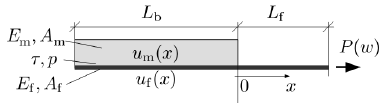

**Remark**: The origin of the coordinate system is placed at the transition between the bond zone and free zone of the fiber. The domain in the bond zone is defined as $x \in (-L_\mathrm{b},0)$. As a result, in the bond domain $x < 0$.

The meaning of the variables defining the idealization is summarized in the table

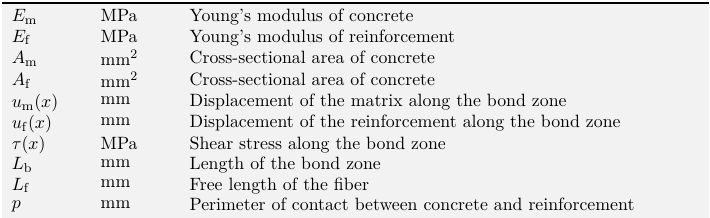

The pull-out test is controlled by the displacement at the end of the fiber $w$. 
The force $P$ is measured to obtain the pull-out curve $P(w)$

### Simplifications

**Simplification 1:** We assume that the interface between steel and concrete transfers a constant shear stress independently on the amount of slip, i.e.
\begin{align}
 \tau(s) = \bar{\tau}
\end{align}
were $\tau$ is a constant material parameter.

**Simplification 2:** We consider $L_\mathrm{b} = \infty$. Thus, the pull-out process can continue infinitely.

## Model parameters

The parameters and variables involved in the are grouped according geometry, material behavior, measured response, internal state and subsidiary integration parameters that will be resolved during the model derivation. In this classification we also associate the mathematical symbols with the Python variable name introduced in the next cell.

**Geometrical variables:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `A_f` | $A_\mathrm{f}$ |  Cross section area modulus of the reinforcement |
| `A_m` | $A_\mathrm{m}$ |  Cross section area modulus of the matrix |
| `p`   | $p$            |  Perimeter of the reinforcement                  |
| `L_b` | $L_\mathrm{b}$ |  Length of the bond zone of the pulled-out bar   |
| `x`   | $x$            |  Longitudinal coordinate |

**Material parameters:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `E_f`     | $E_\mathrm{f}$ |  Young's modulus of the reinforcement |
| `E_m`     | $E_\mathrm{m}$ |  Young's modulus of the matrix |
| `tau_bar` | $\bar{\tau}$   |  Frictional bond stress               |


**Control parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `P` | $P$ | Pullout force |
| `w` | $w$ | pullout control  displacement

**State parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `a` | $a$ | Length of the debonded zone |

**Integration constants:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `C`, `D` | $C,D$ | Integration constants to be resolved through boundary and continuity conditions |

**Let's import the packages:**

In [5]:
%matplotlib notebook
import sympy as sp # symbolic algebra package
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
sp.init_printing() # enable nice formating of the derived expressions
import ipywidgets as ipw
#import bmcs_pullout_ui as poui

In [7]:
import bmcs_ipw.PO_constant_bond as poui

In [ ]:
import sys
import os.path as op 
hdir = op.expanduser('~')
sys.path.insert(0,op.join(hdir,'git','bmcs'))

In [8]:
from bmcs.pullout.pullout_sim import PullOutModel
po = PullOutModel()
po.sim

reconstructed model


In [9]:
%%capture
po = PullOutModel(n_e_x=60, k_max=5, w_max=1.0)
po.sim.tline.step = 0.05
po.fixed_boundary = 'loaded end (matrix)'
po.loading_scenario.trait_set(loading_type='cyclic',
                              amplitude_type='constant',
                              loading_range='non-symmetric'
                              )
po.loading_scenario.trait_set(number_of_cycles=1,
                              unloading_ratio=0.98,
                              )
po.geometry.trait_set(L_x=1.0)
po.cross_section.trait_set(A_f=1, P_b=1, A_m=1)
po.mats_eval_type = 'multilinear'
po.mats_eval.trait_set(E_m=1, E_f=1)
po.mats_eval.bs_law.trait_set(
    xdata=[0, 1e-6, 2.0],
    ydata=[0., 1, 1]
)
po.mats_eval.bs_law.replot()
po.sim.stop()
po.sim.run()

<IPython.core.display.Javascript object>


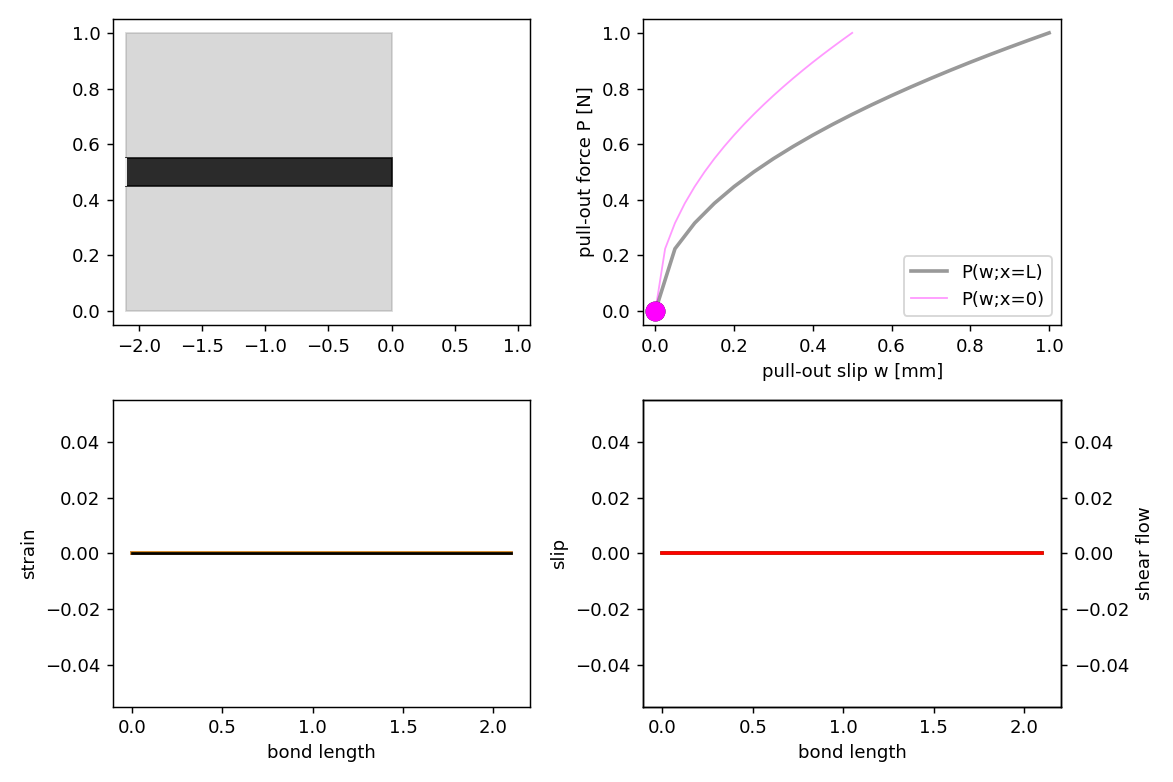

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

interactive(children=(FloatSlider(value=1.0, description='L_b', max=8.0, min=0.5), FloatSlider(value=1.0, desc…

In [10]:
fix, ((ax_geo, ax_Pw),
      (ax_eps, ax_s))= plt.subplots(2,2,figsize=(9,6),
                                   tight_layout=True)
po.plot_geo(ax_geo, 0)
po.hist.plot_Pw(ax_Pw, 0)
po.plot_eps_p(ax_eps, 0)
po.plot_s(ax_s, 0)
ax_sf = ax_s.twinx()
po.plot_sf(ax_sf, 0)

def update_state(t):
    ax_geo.clear()
    po.plot_geo(ax_geo,t)
    ax_Pw.clear()
    po.hist.plot_Pw(ax_Pw,t)
    ax_eps.clear()
    po.plot_eps_p(ax_eps, t)
    ax_s.clear()
    po.plot_s(ax_s, t)
    ax_sf.clear()
    po.plot_sf(ax_sf, t)

def update_material(L_b,tau_2):
    print('updating material', tau_2)
    po.mats_eval.bs_law.trait_set(
        xdata=[0, 1e-6, 2.0],
        ydata=[0., 1, tau_2]
    )
    po.geometry.L_x = L_b
    print('start', tau_2, L_b)
    po.sim.stop()
    po.sim.run()
    print('finished', tau_2, L_b)
    update_state(0)
    
ipw.interact(update_state, t = ipw.FloatSlider(value=0, min=0, max=1, step=0.1));
ipw.interact(update_material, 
             tau_2 = ipw.FloatSlider(value=1, min=0, max=2, step=0.1),
             L_b = ipw.FloatSlider(value=1, min=0.5, max=8, step=0.1));

## How is that implemented?